## Deep Learning for Wheat Disease Classification: A Step Towards Smarter Agriculture.

### Introduction:  
Wheat diseases like rusts, mildews, and blights pose significant threats to global food security by reducing crop yields. This project leverages deep learning, specifically convolutional neural networks (CNNs), to classify 15 wheat diseases using image data. By ensuring accurate and early diagnosis, this model aims to assist farmers in managing diseases more effectively, promoting healthier crops and improved agricultural productivity.  

## 1. Business Understanding
- Objective:
Develop a CNN-based model to classify images of wheat crop pests and diseases to aid smallholder farmers in diagnosis.

- Success Criteria:
Model performance (e.g., accuracy > 90%).
Usability of the model on a web platform.

- Constraints:
Limited internet connectivity in rural areas.
Real-time or near-real-time response requirements.

## Load the necessary Libraries

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

# General
import os
import warnings
warnings.filterwarnings('ignore')

# Image Processing
import cv2
from PIL import Image

# TensorFlow/Keras (consolidated under TensorFlow)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D, 
                                     Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Sklearn
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder


## 2. Data Understanding

#### Load Dataset

In [4]:
# initialize the path to the original input directory of images
data_dir= "C:/Users/USER/OneDrive/Desktop/Image-Classification-Project/Notebooks"
os.listdir(data_dir)

['test', 'train', 'valid']

In [ ]:
# Derive the training, validation, and testing directories
test_path = os.path.join(data_dir, 'test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

print(f"Test Directory: {test_path}")
print(f"Train Directory: {train_path}")
print(f"Validation Directory: {valid_path}")


Test Directory: C:/Users/USER/OneDrive/Desktop/Image-Classification-Project/Notebooks\test
Train Directory: C:/Users/USER/OneDrive/Desktop/Image-Classification-Project/Notebooks\train
Validation Directory: C:/Users/USER/OneDrive/Desktop/Image-Classification-Project/Notebooks\valid


In [7]:
os.listdir(train_path)

['Aphid',
 'Black Rust',
 'Blast',
 'Brown Rust',
 'Common Root Rot',
 'Fusarium Head Blight',
 'Healthy',
 'Leaf Blight',
 'Mildew',
 'Mite',
 'Septoria',
 'Smut',
 'Stem fly',
 'Tan spot',
 'Yellow Rust']

In [ ]:
# List contents of the train directory
try:
    train_classes = os.listdir(train_path)
    print(f"Classes in Train Directory: {train_classes}")
except FileNotFoundError:
    print(f"Directory not found: {train_path}")
except Exception as e:
    print(f"An error occurred: {e}")


Classes in Train Directory: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']


In [9]:
os.listdir(test_path)

['aphid_test',
 'black_rust_test',
 'blast_test',
 'brown_rust_test',
 'common_root_rot_test',
 'fusarium_head_blight_test',
 'healthy_test',
 'leaf_blight_test',
 'mildew_test',
 'mite_test',
 'septoria_test',
 'smut_test',
 'stem_fly_test',
 'tan_spot_test',
 'yellow_rust_test']

In [10]:
os.listdir(valid_path)

['aphid_valid',
 'black_rust_valid',
 'blast_test_valid',
 'brown_rust_valid',
 'common_root_rot_valid',
 'fusarium_head_blight_valid',
 'healthy_valid',
 'leaf_blight_valid',
 'mildew_valid',
 'mite_valid',
 'septoria_valid',
 'smut_valid',
 'stem_fly_valid',
 'tan_spot_valid',
 'yellow_rust_valid']

In [ ]:
# Loop through each class (folder) in the training dataset directory
for cls in os.listdir(train_path):
    # Construct the full path to the class directory
    cls_path = os.path.join(train_path, cls)
    
    # Check if the path is a directory 
    if os.path.isdir(cls_path):
        # Count and print the number of images in the class directory
        print(f"{cls}: {len(os.listdir(cls_path))} images")



Aphid: 903 images
Black Rust: 576 images
Blast: 647 images
Brown Rust: 1271 images
Common Root Rot: 614 images
Fusarium Head Blight: 611 images
Healthy: 1000 images
Leaf Blight: 842 images
Mildew: 1081 images
Mite: 800 images
Septoria: 1144 images
Smut: 1310 images
Stem fly: 234 images
Tan spot: 770 images
Yellow Rust: 1301 images


In [ ]:
 #Function to create a DataFrame containing image paths and their corresponding labels
def create_df(data_dir):

    data = []

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                data.append({'image_path': img_path, 'label': class_name})  

    return pd.DataFrame(data)

# Creating DataFrames for train, validation, and test sets
train_data = create_df(os.path.join(data_dir, 'train'))
valid_data = create_df(os.path.join(data_dir, 'valid'))
test_data = create_df(os.path.join(data_dir, 'test'))

# Display the first few rows of the training DataFrame
train_data.head()

,image_path,label
0,C:/Users/USER/OneDrive/Desktop/Image-Classific...,Aphid
1,C:/Users/USER/OneDrive/Desktop/Image-Classific...,Aphid
2,C:/Users/USER/OneDrive/Desktop/Image-Classific...,Aphid
3,C:/Users/USER/OneDrive/Desktop/Image-Classific...,Aphid
4,C:/Users/USER/OneDrive/Desktop/Image-Classific...,Aphid


#### Class distribution

In [20]:
# Class distribution in the training set
print(train_data['label'].value_counts())

label
Smut                    1310
Yellow Rust             1301
Brown Rust              1271
Septoria                1144
Mildew                  1081
Healthy                 1000
Aphid                    903
Leaf Blight              842
Mite                     800
Tan spot                 770
Blast                    647
Common Root Rot          614
Fusarium Head Blight     611
Black Rust               576
Stem fly                 234
Name: count, dtype: int64


In [21]:
# Class distribution in the training set
print(valid_data['label'].value_counts())

label
aphid_valid                   20
black_rust_valid              20
blast_test_valid              20
brown_rust_valid              20
common_root_rot_valid         20
fusarium_head_blight_valid    20
healthy_valid                 20
leaf_blight_valid             20
mildew_valid                  20
mite_valid                    20
septoria_valid                20
smut_valid                    20
stem_fly_valid                20
tan_spot_valid                20
yellow_rust_valid             20
Name: count, dtype: int64


In [22]:
# Class distribution in the training set
print(test_data['label'].value_counts())

label
aphid_test                   50
black_rust_test              50
blast_test                   50
brown_rust_test              50
common_root_rot_test         50
fusarium_head_blight_test    50
healthy_test                 50
leaf_blight_test             50
mildew_test                  50
mite_test                    50
septoria_test                50
smut_test                    50
stem_fly_test                50
tan_spot_test                50
yellow_rust_test             50
Name: count, dtype: int64


#### Checking and dealing with  missing files

In [25]:
# Checking for corrupted images
corrupted_files = []

for data_dir in [train_path, valid_path, test_path]:
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Verify integrity
                except (IOError, SyntaxError) as e:
                    corrupted_files.append(img_path)

# Report corrupted files
print(f"Found {len(corrupted_files)} corrupted files:")
for file in corrupted_files:
    print(file)

Found 0 corrupted files:


#### Checking for unique labes across the train,valid and test files

In [31]:
# Checking the unique labels across all sets
print(f"Unique labels in training set: {train_data['label'].unique()}")
print(f"Unique labels in validation set: {valid_data['label'].unique()}")
print(f"Unique labels in test set: {test_data['label'].unique()}")

Unique labels in training set: ['Aphid' 'Black Rust' 'Blast' 'Brown Rust' 'Common Root Rot'
 'Fusarium Head Blight' 'Healthy' 'Leaf Blight' 'Mildew' 'Mite' 'Septoria'
 'Smut' 'Stem fly' 'Tan spot' 'Yellow Rust']
Unique labels in validation set: ['aphid' 'black_rust' 'blast' 'brown_rust' 'common_root_rot'
 'fusarium_head_blight' 'healthy' 'leaf_blight' 'mildew' 'mite' 'septoria'
 'smut' 'stem_fly' 'tan_spot' 'yellow_rust']
Unique labels in test set: ['aphid' 'black_rust' 'blast' 'brown_rust' 'common_root_rot'
 'fusarium_head_blight' 'healthy' 'leaf_blight' 'mildew' 'mite' 'septoria'
 'smut' 'stem_fly' 'tan_spot' 'yellow_rust']


In [32]:
# Standardizing label format in all sets (lowercase and remove underscores)
train_data['label'] = train_data['label'].str.lower().str.replace(' ', '_')
valid_data['label'] = valid_data['label'].str.lower().str.replace(' ', '_')
test_data['label'] = test_data['label'].str.lower().str.replace(' ', '_')

# Verify the changes
print(f"Unique labels in training set: {train_data['label'].unique()}")
print(f"Unique labels in validation set: {valid_data['label'].unique()}")
print(f"Unique labels in test set: {test_data['label'].unique()}")

Unique labels in training set: ['aphid' 'black_rust' 'blast' 'brown_rust' 'common_root_rot'
 'fusarium_head_blight' 'healthy' 'leaf_blight' 'mildew' 'mite' 'septoria'
 'smut' 'stem_fly' 'tan_spot' 'yellow_rust']
Unique labels in validation set: ['aphid' 'black_rust' 'blast' 'brown_rust' 'common_root_rot'
 'fusarium_head_blight' 'healthy' 'leaf_blight' 'mildew' 'mite' 'septoria'
 'smut' 'stem_fly' 'tan_spot' 'yellow_rust']
Unique labels in test set: ['aphid' 'black_rust' 'blast' 'brown_rust' 'common_root_rot'
 'fusarium_head_blight' 'healthy' 'leaf_blight' 'mildew' 'mite' 'septoria'
 'smut' 'stem_fly' 'tan_spot' 'yellow_rust']


#### Saving the new dataframe(df)


In [23]:
# Save training df to a CSV file
train_data.to_csv('train_df.csv', index=False)

#### EXPLORATORY DATA ANALYSIS

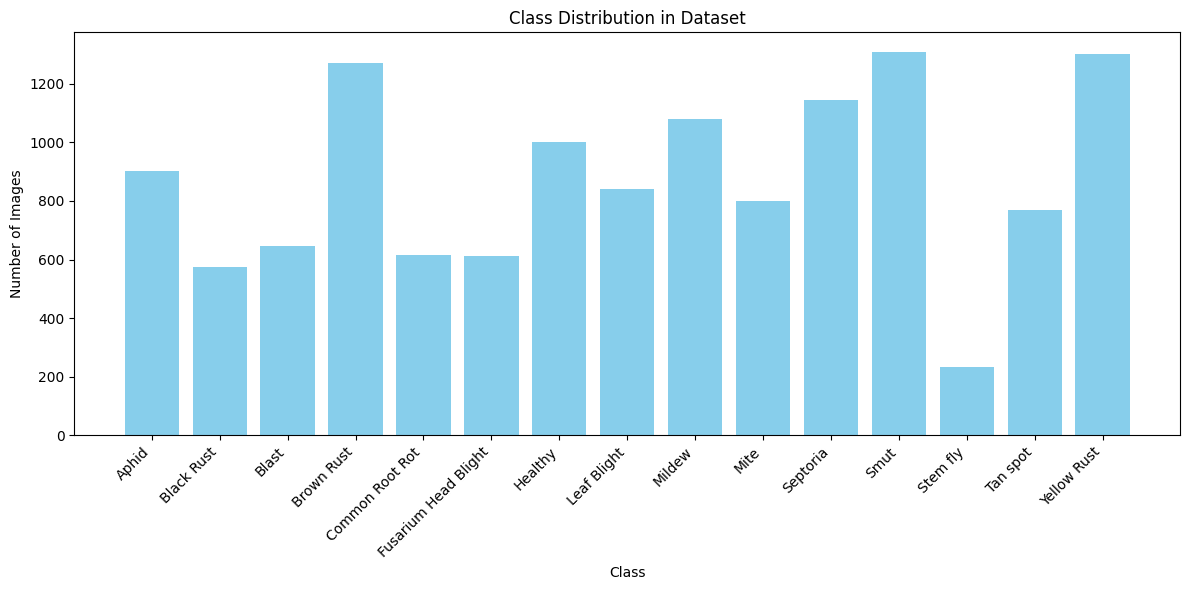

In [ ]:


# Data for visualization
classes = ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 
           'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 
           'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']
image_counts = [903, 576, 647, 1271, 614, 611, 1000, 842, 1081, 800, 1144, 1310, 234, 770, 1301]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(classes, image_counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()


In [ ]:
len(os.listdir(train_path+'\\Mite'))

800

In [ ]:
len(os.listdir(train_path+'\\Aphid'))

903

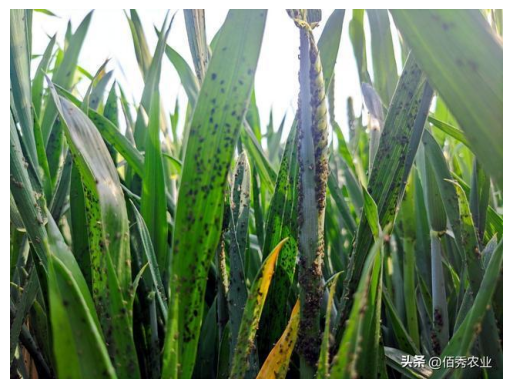

In [ ]:
Aphid_cell = train_path+'\\Aphid\\'+os.listdir(train_path+'\\Aphid')[0]
img = cv2.imread(Aphid_cell)  # Read the image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:


# Choose a random class, e.g., 'Aphid'
class_name = 'Aphid'
class_path = os.path.join(train_path, class_name)

# Pick a random image from the class directory
random_image = os.listdir(class_path)[0]  # First image
image_path = os.path.join(class_path, random_image)

# Read the image using OpenCV
image = cv2.imread(image_path)

# Get the shape of the image
print(f"Image shape for '{class_name}': {image.shape} (Height, Width, Channels)")


Image shape for 'Aphid': (480, 640, 3) (Height, Width, Channels)


### checking dimensions of all images in a directory 

In [ ]:
train_dimensions = []  # List to store image dimensions and class labels

# Loop through each class folder
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        # Loop through each image in the class folder
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    train_dimensions.append({'Class': class_name, 'Width': width, 'Height': height})
            except Exception as e:
                print(f"Error with image {image_path}: {e}")

# Convert to a DataFrame for analysis
df_dimensions = pd.DataFrame(train_dimensions)


In [ ]:
print(train_dimensions[:5])  # Inspect the first 5 entries


[{'Class': 'Aphid', 'Width': 640, 'Height': 480}, {'Class': 'Aphid', 'Width': 500, 'Height': 281}, {'Class': 'Aphid', 'Width': 1024, 'Height': 683}, {'Class': 'Aphid', 'Width': 365, 'Height': 138}, {'Class': 'Aphid', 'Width': 960, 'Height': 720}]


### Visualize Dimensions Using Seaborn
Plot the Width and Height Distributions

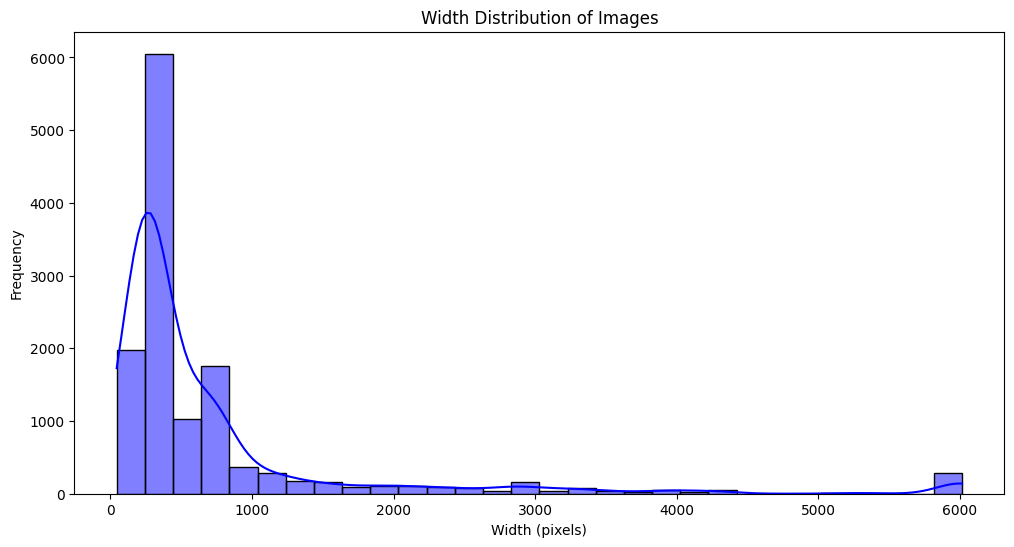

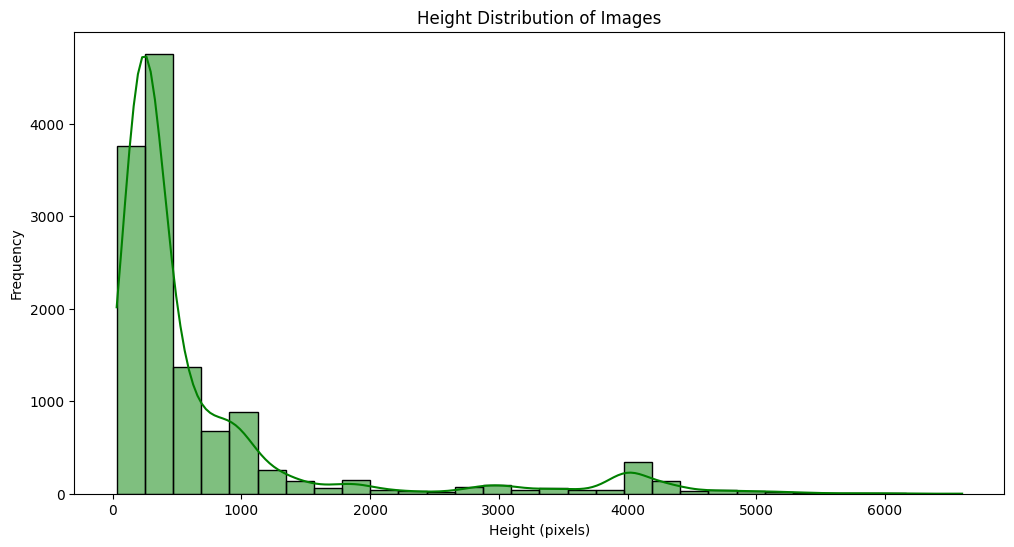

In [ ]:
# Plot Width Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_dimensions['Width'], kde=True, bins=30, color='blue')
plt.title('Width Distribution of Images')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

# Plot Height Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_dimensions['Height'], kde=True, bins=30, color='green')
plt.title('Height Distribution of Images')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

### Joint plot of Height Vs Width

<Figure size 1000x800 with 0 Axes>

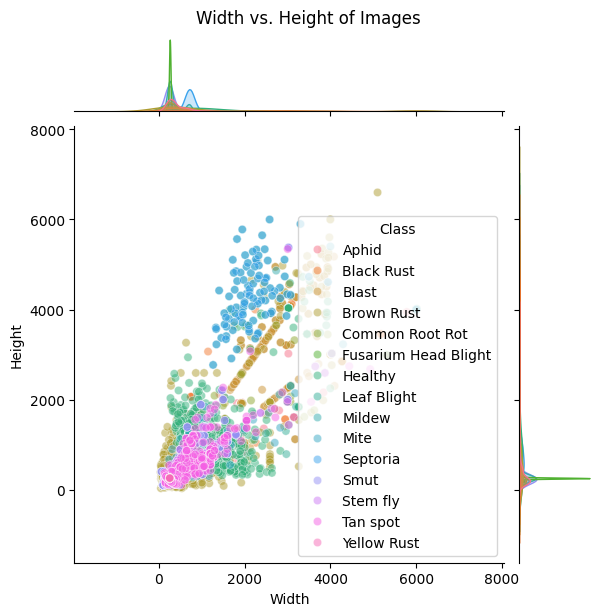

In [ ]:
# plot a jointplot
plt.figure(figsize=(10, 8))
sns.jointplot(data=df_dimensions, x='Width', y='Height', kind='scatter', hue='Class', alpha=0.5)
plt.suptitle('Width vs. Height of Images', y=1.02)
plt.show()


### Analyzing the results

In [ ]:
print(df_dimensions.groupby('Class').agg({'Width': ['mean', 'min', 'max'], 'Height': ['mean', 'min', 'max']}))


                            Width                  Height           
                             mean  min   max         mean  min   max
Class                                                               
Aphid                  466.458472  144  5782   348.715393  112  3946
Black Rust            2645.020833   86  6000  2453.102431  150  5229
Blast                  902.007728  141  6000   845.400309  124  5175
Brown Rust            1211.549961   44  6000  1086.797010   31  6600
Common Root Rot        407.978827  140  3937   348.925081  113  3648
Fusarium Head Blight   264.171849  170   833   254.378069  125   667
Healthy               1609.316000  256  6000  1379.463000  256  4725
Leaf Blight            571.571259  146  6016   739.131829  115  5999
Mildew                 378.267345  167  3072   398.264570  152  4864
Mite                   454.326250  127  4296   339.133750  106  5400
Septoria               841.018357  709  6000   980.657343  471  5999
Smut                   346.480153 

#### Conclusion:
- Resize all images to a consistent size (e.g., 224x224 or 256x256).
- Consider padding to maintain aspect ratios if necessary.
- Normalize images for better model performance.
- Apply data augmentation to improve model generalization.

## 3. Data Preparation

#### Preprocessing:
- Resize images to a uniform size (e.g., 224x224 pixels).
- Normalize pixel values.
- Data augmentation (e.g., rotation, flipping, brightness adjustment) to improve model generalization.

In [28]:
# Resizing and normalizing images
def preprocess_images(df, target_size=(224, 224)):
    images = []
    labels = []
    for _, row in df.iterrows():
        try:
            if '.ipynb_checkpoints' in row['image_path']:
                continue  # Skip .ipynb_checkpoints directories
            img = load_img(row['image_path'], target_size=target_size)  # Resize
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img_array)
            labels.append(row['label'])
        except Exception as e:
            print(f"Error processing image: {row['image_path']} - {e}")
    return np.array(images), np.array(labels)

# Apply preprocessing to training, validation, and test sets
X_train, y_train = preprocess_images(train_data)
X_valid, y_valid = preprocess_images(valid_data)
X_test, y_test = preprocess_images(test_data)

print(f"Training data: {X_train.shape}, Validation data: {X_valid.shape}, Test data: {X_test.shape}")

Training data: (13104, 224, 224, 3), Validation data: (300, 224, 224, 3), Test data: (750, 224, 224, 3)


#### Data Augmentation

In [29]:
# Data augmentation for training set
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augmenting a batch
aug_iter = datagen.flow(X_train, y_train, batch_size=32)
aug_images, aug_labels = next(aug_iter)

#### Standardize the data

In [30]:
# Removing the '_valid' and '_test' suffixes from the labels
train_data['label'] = train_data['label'].str.replace('_valid', '').str.replace('_test', '')
valid_data['label'] = valid_data['label'].str.replace('_valid', '').str.replace('_test', '')
test_data['label'] = test_data['label'].str.replace('_valid', '').str.replace('_test', '')

#### Label Encoding

In [35]:
# Initializing the label encoder and fitting on training set labels
label_encoder = LabelEncoder()
label_encoder.fit(train_data['label'])

# Encoding labels
y_train_encoded = to_categorical(label_encoder.transform(train_data['label']))
y_valid_encoded = to_categorical(label_encoder.transform(valid_data['label']))
y_test_encoded = to_categorical(label_encoder.transform(test_data['label']))

print(f"Encoded training labels: {y_train_encoded.shape}")
print(f"Encoded validation labels: {y_valid_encoded.shape}")
print(f"Encoded test labels: {y_test_encoded.shape}")

Encoded training labels: (13104, 15)
Encoded validation labels: (300, 15)
Encoded test labels: (750, 15)


## 4. Modeling
#### Model Selection:
- Use a Convolutional Neural Network (CNN) architecture, e.g., ResNet, MobileNet, or a custom CNN.

## Creating the Model

#### Using Transfer Learning(MobileNetV2)

In [ ]:


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(15, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                4014144   
                                                                 
 dense_3 (Dense)             (None, 15)                975       
                                                                 
Total params: 6273103 (23.93 MB)
Trainable params: 6238991 (23.80 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________
None


#### Train the Mode

In [38]:
# Adjusting the size of y_train_encoded to match X_train
y_train_encoded = y_train_encoded[:len(X_train)]

print(f"Adjusted y_train_encoded shape: {y_train_encoded.shape}")

Adjusted y_train_encoded shape: (13104, 15)


##### training the data using augmented data

In [39]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Fitting the generator to training data
datagen.fit(X_train)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [45]:
# Compiling the Model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#### Evaluate the Model

In [46]:
# Training the Model
history = model.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=32),
    validation_data=(X_valid, y_valid_encoded),
    epochs=30,  # Adjust based on performance
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
410/410 [==============================] - 4119s 10s/step - loss: 1.3730 - accuracy: 0.5700 - val_loss: 2.3621 - val_accuracy: 0.4833
Epoch 2/30
410/410 [==============================] - 3979s 10s/step - loss: 0.8170 - accuracy: 0.7371 - val_loss: 3.0002 - val_accuracy: 0.5233
Epoch 3/30
410/410 [==============================] - 3856s 9s/step - loss: 0.6579 - accuracy: 0.7822 - val_loss: 2.6376 - val_accuracy: 0.6267
Epoch 4/30
410/410 [==============================] - 4420s 11s/step - loss: 0.5582 - accuracy: 0.8097 - val_loss: 2.0925 - val_accuracy: 0.6633
Epoch 5/30
410/410 [==============================] - 4155s 10s/step - loss: 0.4941 - accuracy: 0.8307 - val_loss: 2.8763 - val_accuracy: 0.7633
Epoch 6/30
410/410 [==============================] - 3803s 9s/step - loss: 0.4320 - accuracy: 0.8500 - val_loss: 2.9424 - val_accuracy: 0.7067
Epoch 7/30
410/410 [==============================] - 3670s 9s/step - loss: 0.3933 - accuracy: 0.8622 - val_loss: 1.6594 - val_accur

In [47]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

24/24 [==============================] - 35s 1s/step - loss: 2.3009 - accuracy: 0.8480
Test Loss: 2.3008923530578613
Test Accuracy: 0.8479999899864197


#### Predicting on test set

In [49]:
# Predicting on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

# Converting true labels back to class labels
y_true = np.argmax(y_test_encoded, axis=1)

# Calculating Precision, Recall, and F1-Score
precision = precision_score(y_true, y_pred_classes, average='weighted')  # Weighted average for imbalanced classes
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Print the metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# classification report 
print(classification_report(y_true, y_pred_classes))

24/24 [==============================] - 41s 1s/step
Precision: 0.8605565441105156
Recall: 0.848
F1-Score: 0.8311443328957554
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        50
           1       0.97      0.72      0.83        50
           2       0.98      0.86      0.91        50
           3       0.78      0.98      0.87        50
           4       0.89      0.94      0.91        50
           5       0.98      0.90      0.94        50
           6       0.67      0.08      0.14        50
           7       0.87      0.78      0.82        50
           8       0.88      1.00      0.93        50
           9       0.79      0.92      0.85        50
          10       1.00      0.92      0.96        50
          11       0.94      0.94      0.94        50
          12       0.98      0.92      0.95        50
          13       0.71      0.80      0.75        50
          14       0.56      1.00      0.71        50

    accu

#### Visualize Training Results

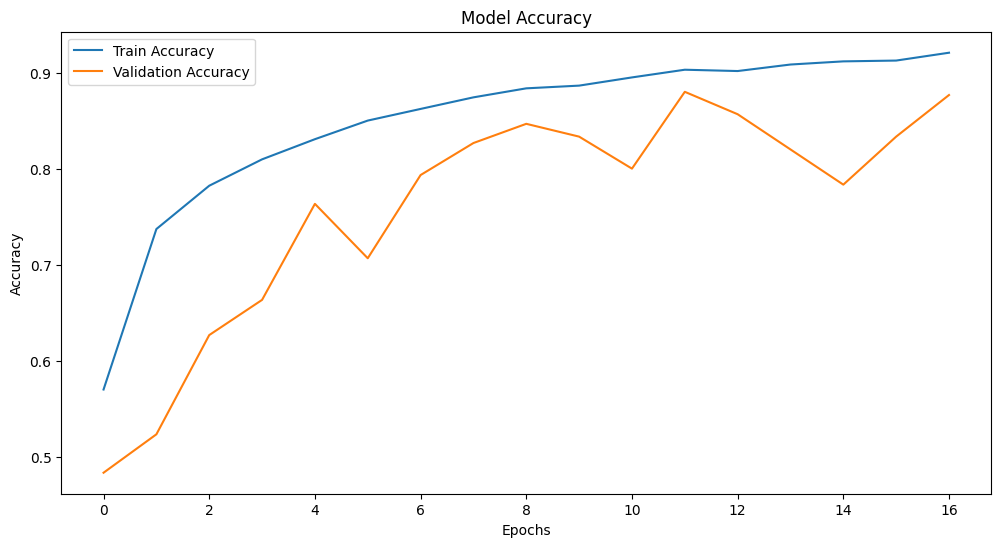

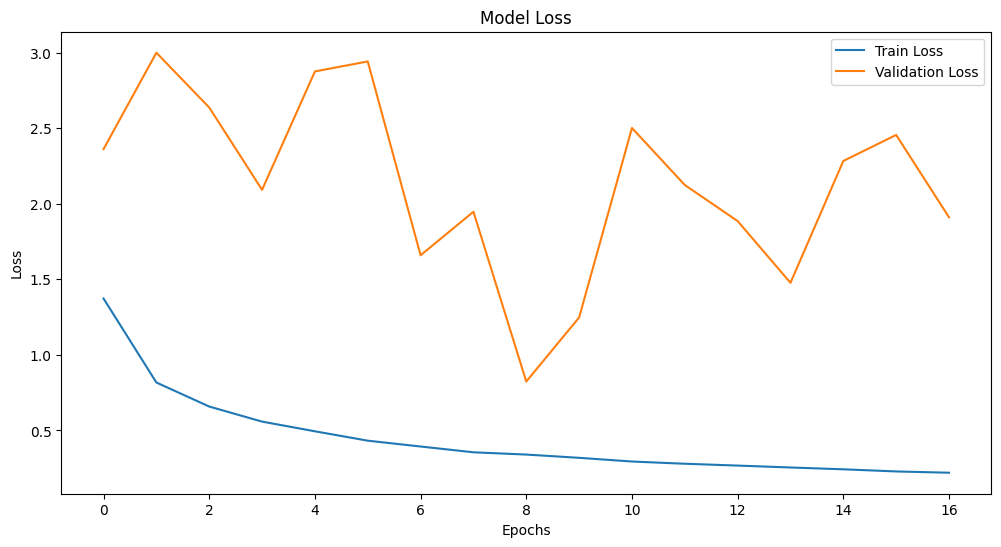

In [ ]:


# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#### Make Predictions

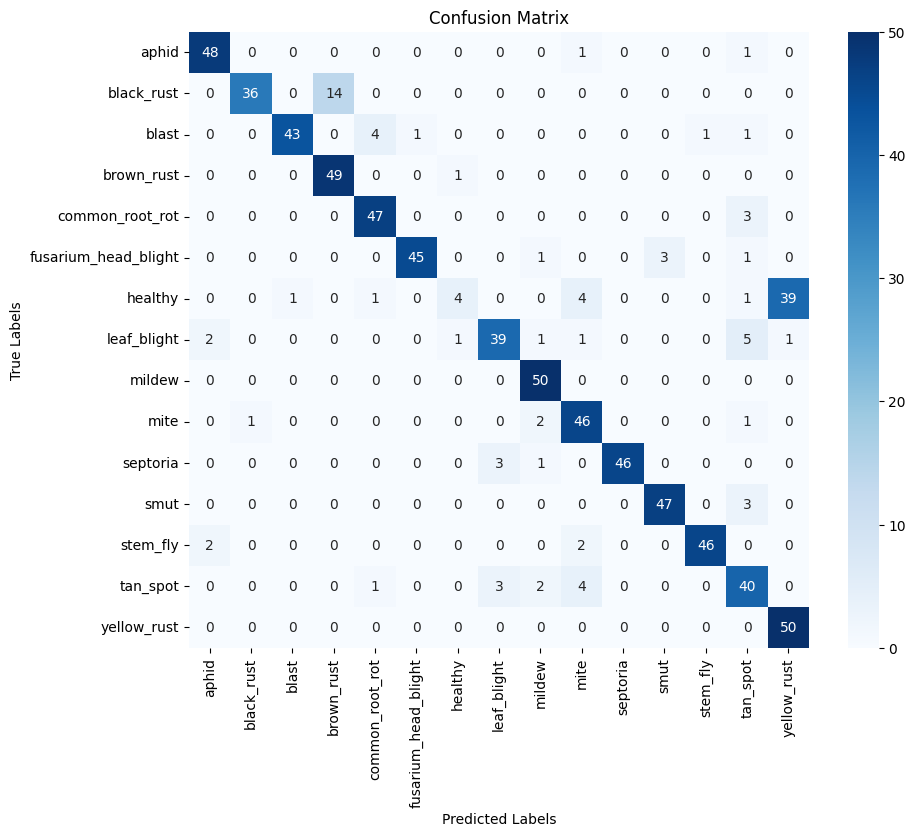

In [ ]:



 #Computing the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


#### Save the Model

In [54]:
model.save('wheat_disease_classification_model.h5')
